# 2D Data Processing Using K-means

This notebook contains an example of 2D Data Processing to perform the Feature Detection
using the k-means algorithm.

In [1]:
from time import time
import matplotlib.pyplot as plt

from pyc2mc.time_dependent.td_data import TimeDependentData
from pyc2mc.processing.roi_detection import KmeansDetection
import matplotlib.pyplot as plt

## 1. Load the data

We start reading the files by using the `TimeDependentData.from_directory()`
method that has the following arguments:

* **directory_path:** input directory.
* **ext (optional):** the extension of the files: `pks, ascii, txt`
* **verbose:** if True it shows the information of the reading procedure.
* **sorting:** if True it sorts the files by index name.

Use the following expressions:

In [2]:
# PKS files
MagLab_data = TimeDependentData.from_directory(
    directory_path="data/200207_A2017/",
    verbose=False
)

In [3]:
MagLab_data

TimeDependentData (900 scans)
Scan 0: 1925 peaks [200.06 ; 1198.13]
Scan 1: 2083 peaks [200.05 ; 1198.90]
Scan 2: 1992 peaks [200.27 ; 1198.90]
Scan 3: 2131 peaks [200.24 ; 1198.91]
Scan 4: 2178 peaks [200.24 ; 1198.90]
Scan 5: 2093 peaks [200.26 ; 1198.90]
...
Scan 895: 2258 peaks [200.06 ; 1198.13]
Scan 896: 2051 peaks [200.05 ; 1198.90]
Scan 897: 2075 peaks [200.27 ; 1198.90]
Scan 898: 2134 peaks [200.24 ; 1198.91]
Scan 899: 2136 peaks [200.24 ; 1198.90]

In [4]:
MagLab_data.data_summary()

retentionTime                mz_bounds  N_peaks        TIC        BPC  \
scan                                                                          
0               0.0   (200.0615, 1198.12687)     1925  22.657074  51.134360   
1               1.0  (200.05361, 1198.89767)     2083  24.449061  42.010783   
2               2.0  (200.26996, 1198.89918)     1992  23.095975  41.931097   
3               3.0     (200.2446, 1198.907)     2131  24.913257  44.598229   
4               4.0  (200.24401, 1198.89902)     2178  24.658052  45.981339   
...             ...                      ...      ...        ...        ...   
895           895.0  (200.41086, 1198.82849)     2258  26.207287  49.622447   
896           896.0  (200.41111, 1199.47609)     2051  24.102376  50.288605   
897           897.0   (200.20112, 1198.8201)     2075  24.062412  49.812178   
898           898.0  (200.39119, 1198.82627)     2134  24.135586  53.164745   
899           899.0  (200.41219, 1198.82621)     2136  23.658057  49.885227   

        mz_max_I  
scan              
0     1100.50333  
1      254.35937  
2     1100.50037  
3     1100.48998  
4     1100.48897  
...          ...  
895    254.35940  
896    254.35941  
897    254.35941  
898   1100.37812  
899    254.35941  

[900 rows x 6 columns]

## 2. Manage the raw data

Some functions can be use to delimit the range of scans, or masses. For example, to limit the range of scans from 300 to 700 in this case you can use the following expression:

In [5]:
new_data = MagLab_data[300:700]

In [6]:
new_data

TimeDependentData (400 scans)
Scan 300: 2130 peaks [200.16 ; 1198.97]
Scan 301: 2195 peaks [200.07 ; 1198.97]
Scan 302: 2195 peaks [200.39 ; 1198.98]
Scan 303: 2112 peaks [200.33 ; 1199.44]
Scan 304: 2143 peaks [200.35 ; 1198.97]
Scan 305: 2144 peaks [200.39 ; 1198.97]
...
Scan 695: 2356 peaks [200.16 ; 1198.97]
Scan 696: 2359 peaks [200.07 ; 1198.97]
Scan 697: 2345 peaks [200.39 ; 1198.98]
Scan 698: 2200 peaks [200.33 ; 1199.44]
Scan 699: 2268 peaks [200.35 ; 1198.97]

Use the `delimit_segments` function to limit the m/z range as follows:

In [7]:
new_data = new_data.delimit(mz_bounds=(100, 900))

Plot the Total Ion Chromatogram :

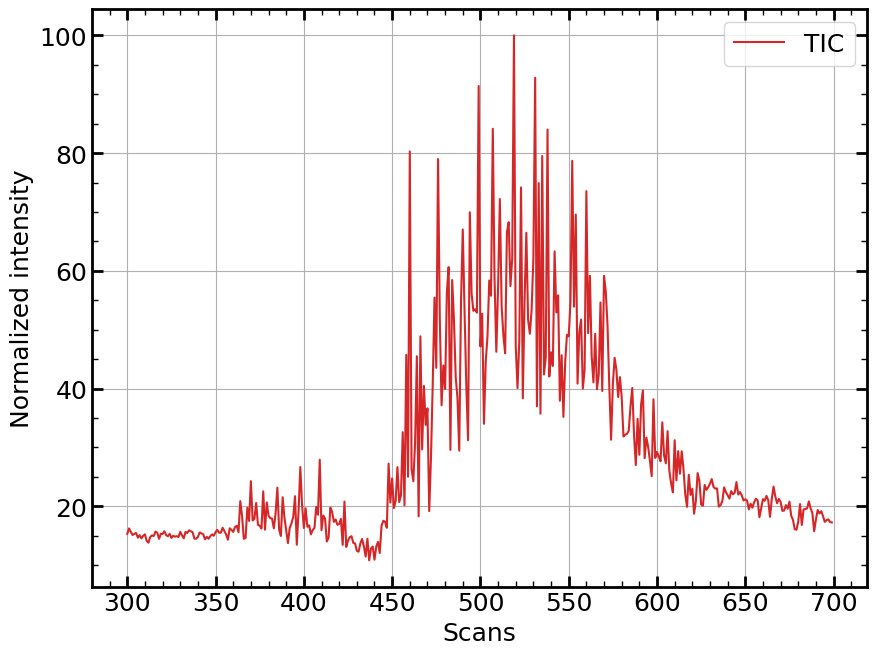

In [8]:
new_data.plot()

## 3. Feature Detection

### 3.2 Perform the Regions of Interest Detection using Kmeans

The next step is to process data using the `KmeansDetection`. Kmeans Algorithm uses the clustering approach by nominal mass. The following parameters must be specifyied:

* **raw_data:** object containing the lists of masses and intensities from the time-resolved data (scans).
* **min_centroids:** minimum number of consecutive points to consider a feature as a ROI. For defining this value it could be helpful to know the minimum chromatographic peak width.
* **lambda_parameter:** this value is the mass accuracy of the mass spectra, it is given in ppm. It has a default value of 10 ppm.
* **continuity_min:** minimum number of scans to check if a ROI is taken as one or if it is splitted due to this minimum separation. It has a default value of 1, if it is not set. A value of 1 means that if a ROI is not continue in the scan order it will be splitted. A value of two implies that if a disonctinuity of one scan exists, it is negligable, so the ROI is not splitted, even with this void.
* **clustering_model:** options 'ckmeans' for using ckwarp.ckmeans methodology by Wang & Song (2011), or 'sklearn' to use the sklearn.cluster.k_means approach.
* **sklearn_algorithm:** {"auto", "full", "elkan"}, default="auto" K-means algorithm to use. See more information in sklearn.cluster for the k_means function. 

In [9]:
start = time()

# setup the object
km = KmeansDetection(
    raw_data=new_data,
    min_centroids=6,
    lambda_parameter=1,
    continuity_min=6,
)

# run the detection
roi = km.run()

end = time()
print(f"Elapsed time: {end - start:.1f} s") 

Elapsed time: 27.4 s


Plot the resulting analyisis:

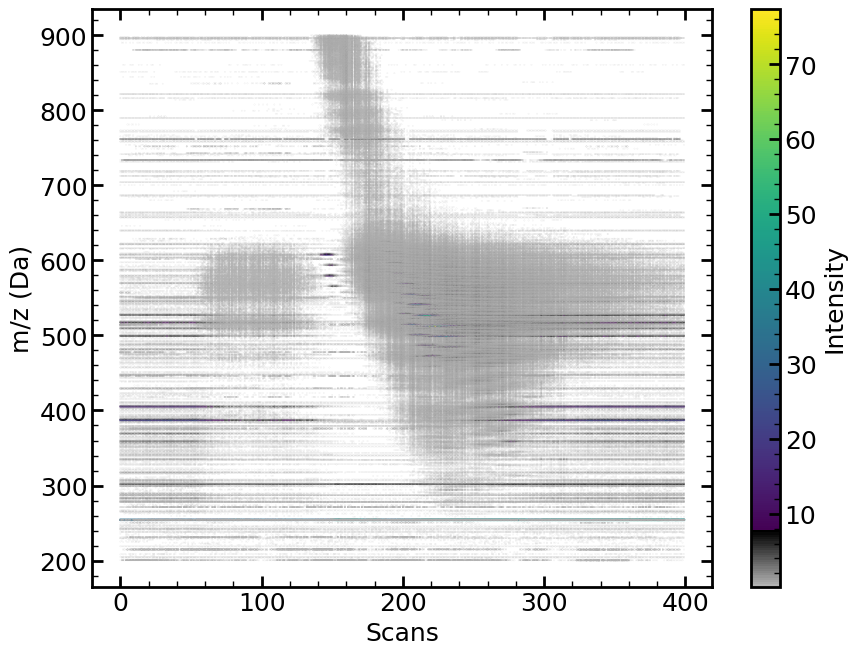

In [10]:
roi.plot(markersize=2, scale_intensity=True)

Compare original TIC and TIC from ROI.

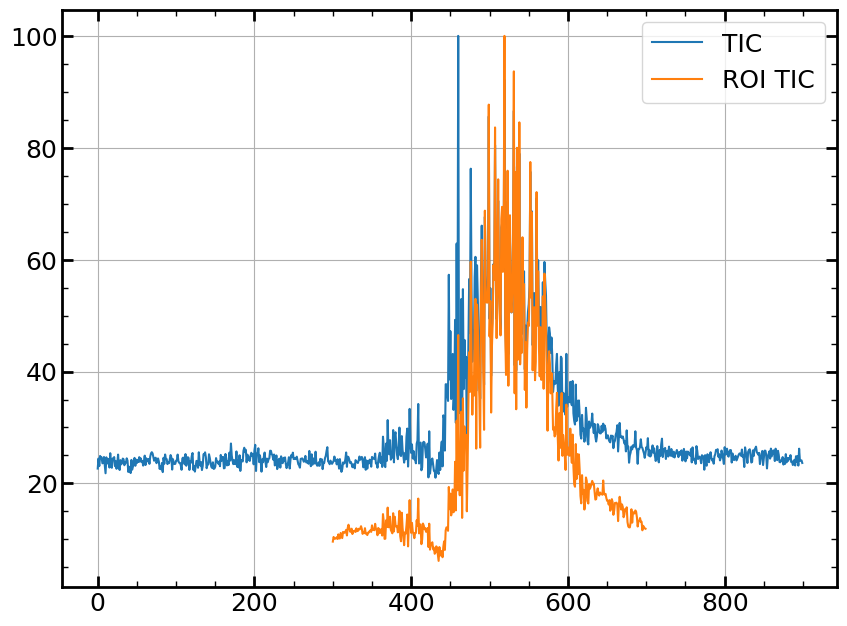

In [11]:
tic = MagLab_data.get_total_ion_chromatogram()
t = MagLab_data.get_retention_times()

roi_t, roi_tic = roi.get_total_ion_chromatogram()
roi_t += 300
#roi_t = roi.get_retention_times(t0=300)

plt.plot(t, tic, label="TIC")
plt.plot(roi_t, roi_tic, label="ROI TIC")
plt.legend()

zoom in the plot on a certain region:

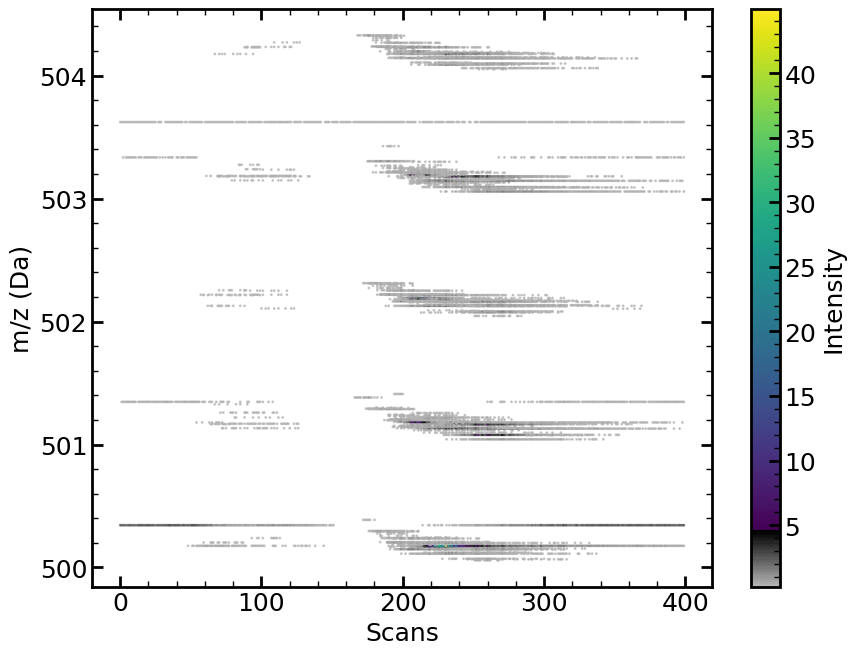

In [12]:
roi.plot(mz_bounds=(500, 505), markersize=1, scale_intensity=False)

### 3.2 Cleaning Noise

To clean long features that are considered as noise or contaminants, the following 
procedure could be performed using the `remove_roi_in_range` method.

First we remove signals considered as noise if they exist in a region of the time
axis in which only noise signals are supossed to appear. The algorithm
will delete all signals that belongs to this interval among all the
time range.

Here we look for signals that span the whole scan range between scans 0 and 50.


In [13]:
filtered_roi = roi.remove_roi_in_range(
    threshold=.9,
    scan_bounds=(0, 50),
)

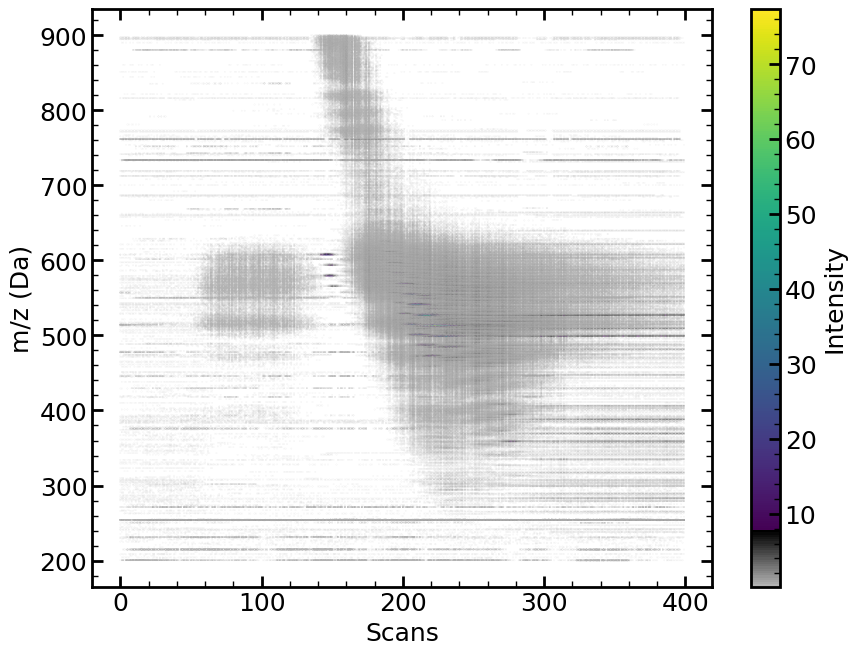

In [14]:
filtered_roi.plot(markersize=1, scale_intensity=True)

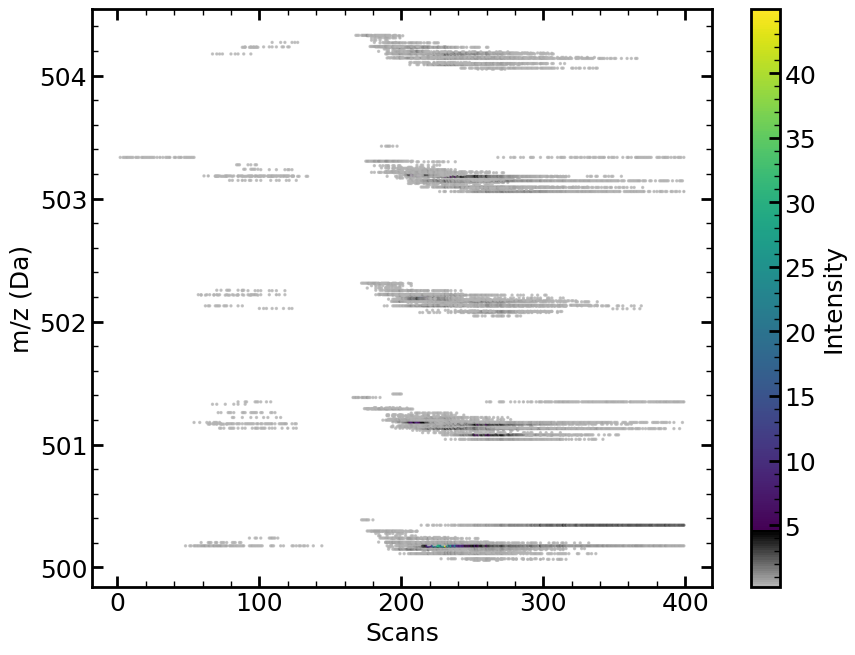

In [15]:
filtered_roi.plot(mz_bounds=(500, 505), scale_intensity=False, markersize=2)

### 3.3 Explore Regions of Interest (ROI)

Now we will look for ROI in a specific mass range.

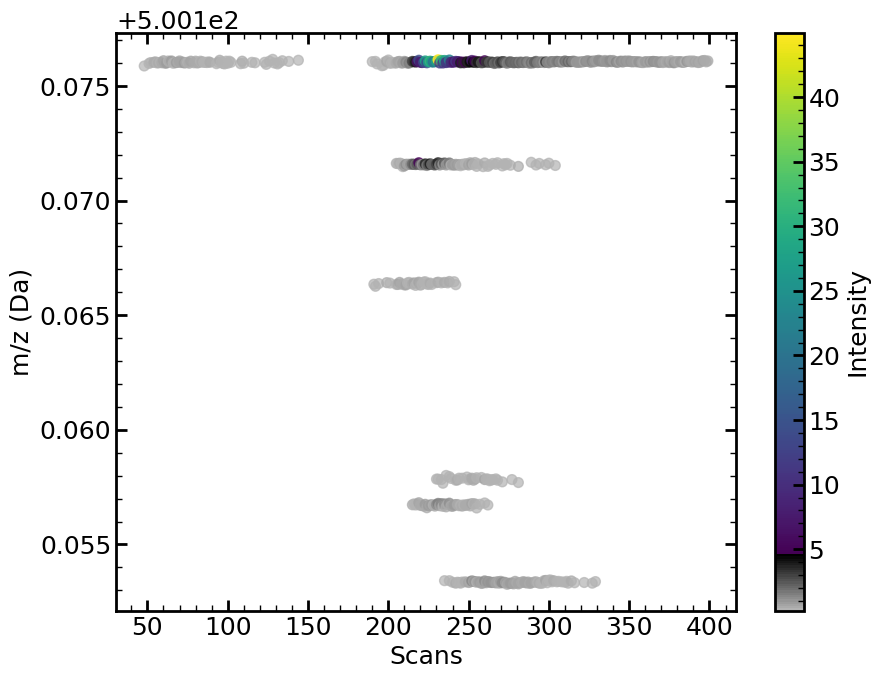

In [16]:
filtered_roi.plot(mz_bounds=(500.15, 500.18))

In [17]:
idx = filtered_roi.find_roi(500.175, lambda_parameter=4)
idx

 9843 500.176033 +/- 4.43e-05 (63 points)
 9844 500.176063 +/- 3.88e-05 (207 points)


array([9843, 9844])

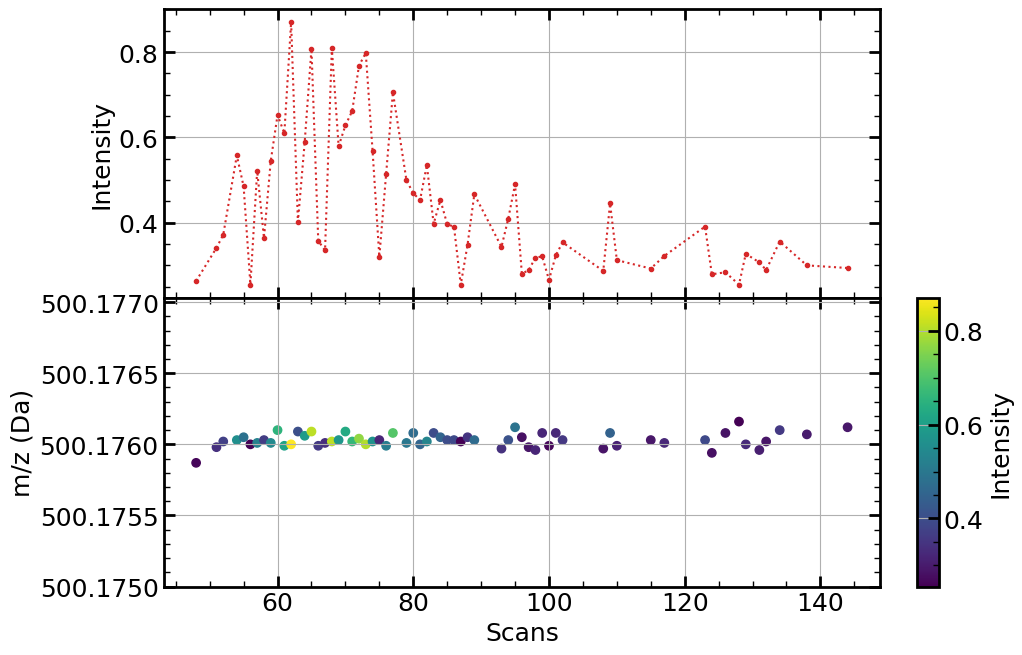

In [18]:
filtered_roi[9843].plot();

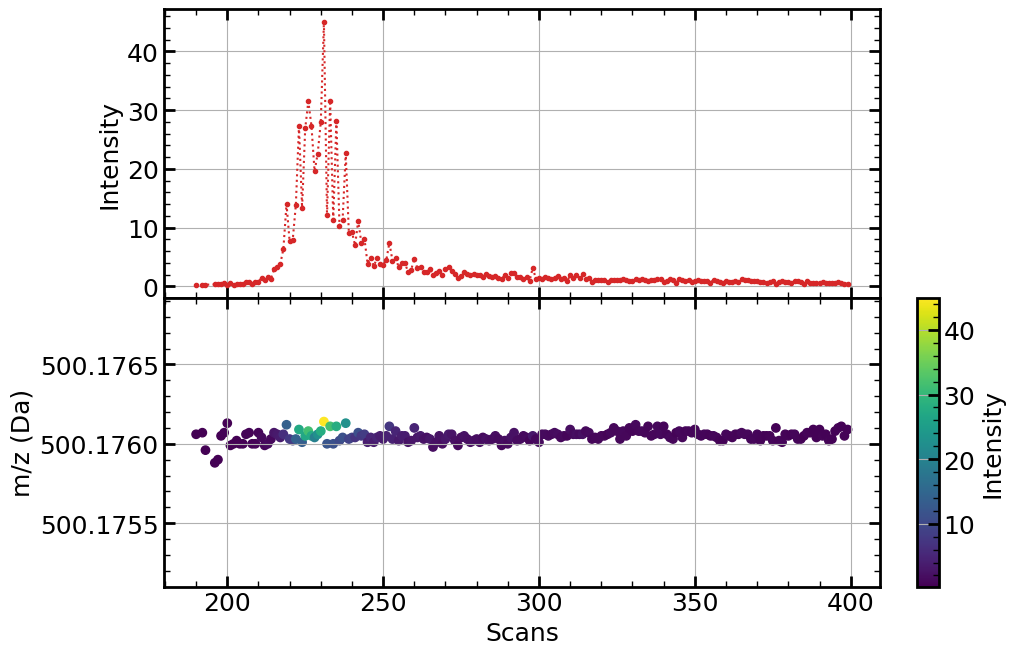

In [19]:
filtered_roi[9844].plot();

### 4. Get and Attribute the averaged PeakList

Hereafter, an average peaklist is built from the detected ROI and then attributed.

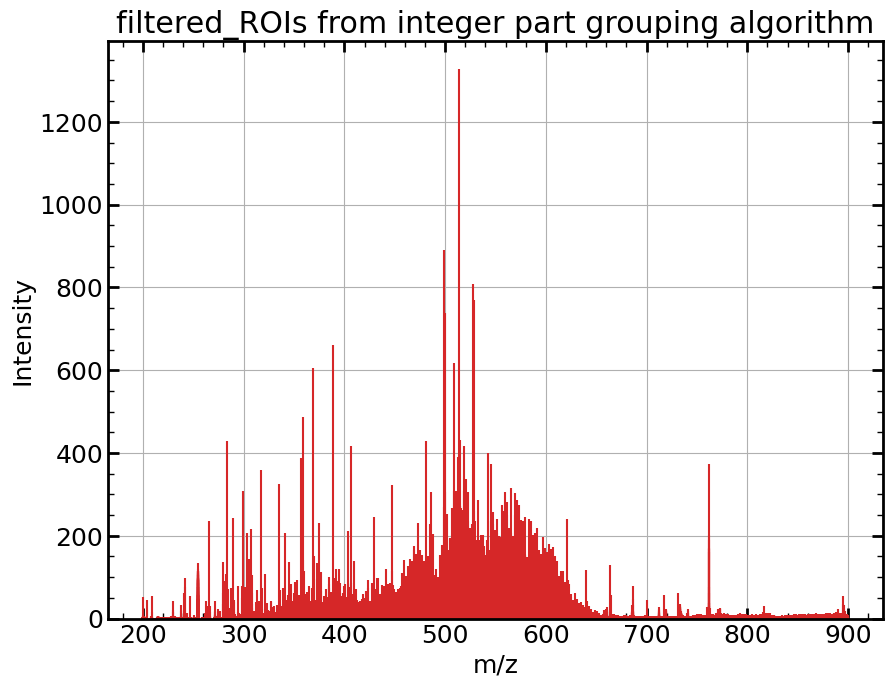

In [20]:
filtered_roi.get_ave_peaklist().plot();

### 4.1 Recalibration

This part is for illustration only. If needed, calibration should be done before feature detection.

In [22]:
from pyc2mc.processing.recalibration import Recalibration
from pyc2mc.io.caliblist import CalibList

# define the calibration list from some internal calibrants
mass_list = [499.169720, 542.224495, 513.185370, 486.1618949, 570.255795, 606.255795, 620.2714454]
mass_exp = [499.168240, 542.222799, 513.183821, 486.160469, 570.253937, 606.253731, 620.269269]
cl = CalibList(mz_theo=mass_list, mz_exp=mass_exp, polarity=1)
print(cl)

recal = Recalibration(
    calibration_list=cl,
    model="polynomial", deg=2,
    fit_intercept=True,
    verbose=True
)

recal_pl = recal.recalibrate(filtered_roi.get_ave_peaklist())

CalibList (7 peaks) 486.16 -> 620.27
Calibration Point: 486.16
Calibration Point: 499.17
Calibration Point: 513.19
Calibration Point: 542.22
Calibration Point: 570.26
Calibration Point: 606.26
Calibration Point: 620.27
CALIBRATION SUMMARY
-------------------
Calibration list             : calibration_list
Number of data points        : 7
Regression model             : RecalibrationModels.POLYNOMIAL
Polynomial degree            : 2
Parameters of the model      : A: 9.15582e-09 B: 9.99995e-01 C: 1.48828e-03
Root mean squared error (ppm): 0.011262
Calibration mz range         : 486.16, 620.27

Calibrating peaklist: filtered_ROIs from integer part grouping algorithm
24061 peaks (200.36 -> 899.77) Da


In [23]:
from pyc2mc.processing.standard_attribution import isotopic_pattern_attribution
from pyc2mc.core.formula_grid import FormulaGrid

Attribution using a formula grid:

<div class="alert alert-warning">

**Remark:** This formula grid aims to attribute only vanadyl porphyrins. We
set the presence of vanadium and four nitrogen as mandatory for all formulas.
    
</div>

In [24]:
#Define the first iteration and then add each step
fg = FormulaGrid(
    elements=["C", "H", "N", "O", "S", "V"],
    limits=[[1, 100], [1, 200], [4, 4], [1, 1], [0, 0], [1, 1]],
    H_C_bounds=[0.3, 2.4],
    dbe_bounds=[0, 50],
    mass_bounds=[100, 900],
    polarity=1,
    element_ratios={('O','C'):(0,0.8)},
    isotopes={(6, 13): 2},
)

In [25]:
# Attribute the recalibrated peak list
attr_pl = isotopic_pattern_attribution(
    peaklist=recal_pl,
    formula_grid=fg,
    lambda_parameter=0.3,
    use_isotopes=True,
)

Summary of results:

In [26]:
attr_pl.summary()

 Attribution results:
 Total number of peaks: 24061
 Attributed peaks     : 388
 Mean error (ppm)     : 0.00461
 Std error (ppm)      : 0.06275
 Attributed percentage: 1.61 %
 hits percentage      : 5.08 %


In [27]:
attr_pl.get_classes()

Chem. Group    Chem. Class     Intensity  Relative abundance (%)  \
0       O N V       O1 N4 V1  11738.561887               77.331428   
1   O N V 13C  O1 N4 V1 13C1   3168.108454               20.870900   
2   O N V 13C  O1 N4 V1 13C2    272.878495                1.797672   

   Cumulative abundance (%)  
0                 77.331428  
1                 98.202328  
2                100.000000

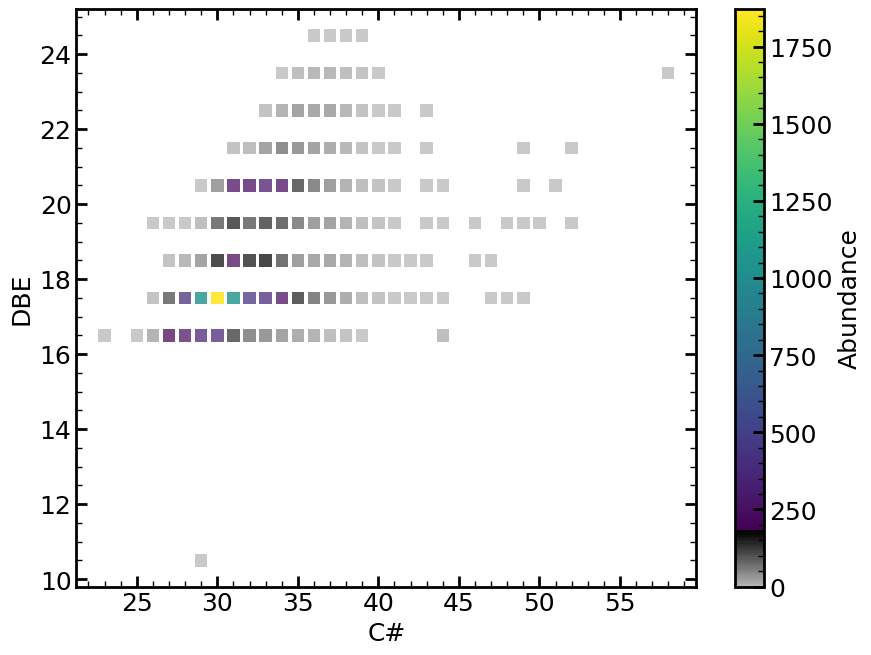

In [28]:
attr_pl.plot.plot_dbe('O1 N4 V1', markersize=80, non_integer_dbe=True)

In [29]:
attr_pl.to_dataframe(attributed_only=True)

mz  intensity                formula  polarity  error_ppm  \
7265   418.099174   2.119711       C23 H19 O1 N4 V1         1   0.289069   
7827   445.122814  16.360122       C25 H22 O1 N4 V1         1  -0.100178   
7988   446.126142   2.325397  C24 H22 O1 N4 V1 13C1         1  -0.039622   
7991   446.130638   2.385092       C25 H23 O1 N4 V1         1  -0.097700   
8168   454.099329   3.247711       C26 H19 O1 N4 V1         1  -0.076445   
...           ...        ...                    ...       ...        ...   
21514  790.474954   2.223924       C50 H67 O1 N4 V1         1  -0.072544   
21782  802.474976   2.345670       C51 H67 O1 N4 V1         1  -0.099474   
21969  814.474956   2.151002       C52 H67 O1 N4 V1         1  -0.073503   
22092  818.506273   2.459986       C52 H71 O1 N4 V1         1  -0.093382   
23850  894.537439   5.343683       C58 H75 O1 N4 V1         1   0.064763   

       attributed attribution_method  
7265         True       lowest_error  
7827         True   isotopic_pattern  
7988         True           isotopes  
7991         True       lowest_error  
8168         True       lowest_error  
...           ...                ...  
21514        True       lowest_error  
21782        True       lowest_error  
21969        True       lowest_error  
22092        True       lowest_error  
23850        True       lowest_error  

[388 rows x 7 columns]

To export the results as csv:

```python
attr_pl.to_viewer('Results_KmeansDetection_Assignment.csv')
```